# Predicción del Rendimiento de Fernando Alonso en la Temporada de Fórmula 1 utilizando Machine Learning

## Introducción

En este proyecto, aplicamos técnicas de análisis de datos y machine learning para predecir la posición final de Fernando Alonso en la clasificación de la Fórmula 1. Utilizamos un enfoque basado en la simulación de carreras futuras y el análisis de datos históricos para proporcionar una predicción confiable. Este proyecto demuestra cómo los datos deportivos pueden ser utilizados para generar predicciones precisas y cómo el análisis estadístico puede ofrecer una visión estratégica en el ámbito deportivo.

Hemos obtenido el dataSet de la siguiente fuente: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?select=circuits.csv

### Fran Moreno y Pablo Moreno

## Obtención y análisis de datos

Comenzaremos importando las librerías necesarias y cargando los datos

In [48]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Cargamos los datos de 5 dataframes diferentes, ya que queremos utilizar diferentes variables que aparecen en solo algunos dataframes. "Results.csv" es nuestro dataframe principal, y del que sacaremos la mayoría de características relevantes.

In [49]:
results = pd.read_csv(r"C:/Users/moren/Downloads/results.csv")
races = pd.read_csv(r"C:/Users/moren/Downloads/races.csv")
drivers = pd.read_csv(r'C:/Users/moren/Downloads/drivers.csv')
constructors = pd.read_csv(r'C:/Users/moren/Downloads/constructors.csv')
status = pd.read_csv(r'C:/Users/moren/Downloads/status.csv')

Combinamos los dataframes cargados en uno solo, para ello hacemos un "merge" usando los IDs que tienen en común. Estos Ids son: "raceID", "driverID", "constructorID" y "statusID".  

In [50]:
df = pd.merge(results,races[['raceId','year','name','round']],on = 'raceId',how = 'left')
df = pd.merge(df,drivers[['driverId','driverRef','nationality']],on = 'driverId',how ='left')
df = pd.merge(df,constructors[['constructorId','name','nationality']],on ='constructorId',how ='left')
df = pd.merge(df,status[['statusId', 'status']],on ='statusId',how ='left')

Antes de hacer drop, vamos a guardar un df con todos los strings y los ids para hacer un análisis más profundo de los datos

In [51]:
df_data = df

Tenemos algunas columnas que no necesitamos, así que las vamos a eliminar. Esto lo hacemos para evitar datos redundantes e irrelevantes, lo cual beneficiará a nuestro modelo K-vecinos.

In [52]:
df.drop(['number','position','positionText','laps','fastestLap','statusId','resultId',
         'raceId','driverId','constructorId'],axis =1,inplace = True)

Renombraremos algunas columnas para que no coincidan sus nombres:

In [53]:
df.rename(columns = {'rank':'fastest_lap_rank','name_x':'gp_name','nationality_x':'driver_nationality',
                    'name_y':'constructor_name','nationality_y':'constructor_nationality','driverRef':'driver'},inplace = True)

Reordenamos las columnas de una mejor manera:

In [54]:
df = df[['year','gp_name','round','driver','constructor_name','grid','positionOrder','points','time',
         'milliseconds','fastest_lap_rank','fastestLapTime','fastestLapSpeed',
        'driver_nationality','constructor_nationality']]

Eliminamos las filas en las que no compitió Fernando Alonso (1950-2000 && 2019/2000)

In [55]:
df = df[df['year'] >= 2001]

In [56]:
df= df[df['year']!=2019]
df= df[df['year']!=2020]

Reordenamos las filas en base al año, posición en la clasificación, y ronda de la carrera:

In [57]:
df = df.sort_values(by =['year','round','positionOrder'],ascending=[False,True,True])

Cambiamos el valor de los valores '\n' por el valor "NaN". Esto es necesario, ya que cuando un conductor no ha terminado la carrera no queda registrado ningún tiempo de carrera.

In [58]:
df.time.replace('\\N',np.nan,inplace = True)
df.milliseconds.replace('\\N',np.nan,inplace = True)
df.fastest_lap_rank.replace('\\N',np.nan,inplace = True)
df.fastestLapTime.replace('\\N',np.nan,inplace = True)
df.fastestLapSpeed.replace('\\N',np.nan,inplace = True)

Llamamos a head() para ver como ha quedado el dataframe por el momento:

In [59]:
df.head()

,year,gp_name,round,driver,constructor_name,grid,positionOrder,points,time,milliseconds,fastest_lap_rank,fastestLapTime,fastestLapSpeed,driver_nationality,constructor_nationality
25400,2022,Bahrain Grand Prix,1,leclerc,Ferrari,1,1,26.0,1:37:33.584,5853584,1,1:34.570,206.018,Monegasque,Italian
25401,2022,Bahrain Grand Prix,1,sainz,Ferrari,3,2,18.0,+5.598,5859182,3,1:35.740,203.501,Spanish,Italian
25402,2022,Bahrain Grand Prix,1,hamilton,Mercedes,5,3,15.0,+9.675,5863259,5,1:36.228,202.469,British,German
25403,2022,Bahrain Grand Prix,1,russell,Mercedes,9,4,12.0,+11.211,5864795,6,1:36.302,202.313,British,German
25404,2022,Bahrain Grand Prix,1,kevin_magnussen,Haas F1 Team,7,5,10.0,+14.754,5868338,8,1:36.623,201.641,Danish,American


Comprobamos que no nos falte ningún valor:

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8027 entries, 25400 to 2929
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     8027 non-null   int64  
 1   gp_name                  8027 non-null   object 
 2   round                    8027 non-null   int64  
 3   driver                   8027 non-null   object 
 4   constructor_name         8027 non-null   object 
 5   grid                     8027 non-null   int64  
 6   positionOrder            8027 non-null   int64  
 7   points                   8027 non-null   float64
 8   time                     3618 non-null   object 
 9   milliseconds             3618 non-null   object 
 10  fastest_lap_rank         6831 non-null   object 
 11  fastestLapTime           6635 non-null   object 
 12  fastestLapSpeed          6635 non-null   object 
 13  driver_nationality       8027 non-null   object 
 14  constructor_national

Como vemos, todas las columnas excepto las que pueden tener valores "NaN", tienen 8027 valores, por lo que no nos falta nada. También vemos que tenemos 15 columnas, así que mostraremos la matriz de correlación para ver las relaciones entre variables. 

Antes de calcular la matriz de correlación, debemos cambiar el tipo de algunas de nuestras variables, ya que no se calcula la correlación entre las variables de tipo 'Object' 

In [61]:
##### eliminamos los carácteres no númericos para poder convertirlos a float
df['fastestLapTime'] = df['fastestLapTime'].str.replace(':', '').astype(float)
df['milliseconds'] = df['milliseconds'].str.replace(':', '').astype(float)


In [62]:
df.fastestLapSpeed = df.fastestLapSpeed.astype(float)
df.fastest_lap_rank = df.fastest_lap_rank.astype(float)
df.fastestLapTime = df.fastestLapTime.astype(float)
df.milliseconds = df.milliseconds.astype(float)

Para las correlaciones, eliminamos las variables que son String para que no nos de error, pero antes, copiamos el dataFrame tal y como está en un dataFrame solo con Fernando Alonso como conductor, ya que es el dataframe que usaremos con nuestros modelos.

In [63]:
df_alonso = df[df["driver"] == "alonso"]

In [64]:
# Verificar si las columnas están presentes en df_alonso
drop_columnas = ['driver', 'gp_name', 'constructor_name', 'time', 'driver_nationality', 'constructor_nationality']
drop_columnas = [col for col in drop_columnas if col in df.columns]

# Eliminar las columnas del DataFrame
df.drop(drop_columnas, axis=1, inplace=True)

In [65]:
correlations = df.corr()['points'].sort_values(ascending=True)

# Imprimir las correlaciones de mayor a menor
print(correlations)

positionOrder      -0.734014
grid               -0.554071
fastest_lap_rank   -0.548507
fastestLapTime     -0.049249
milliseconds        0.029410
round               0.036889
fastestLapSpeed     0.079170
year                0.229607
points              1.000000
Name: points, dtype: float64


Observamos la correlación de las variables con la variable "points". Vemos que las variables "positionOrder" y "grid" son las más relevantes en nuestro análisis y ambas tienen correlación negativa con "points". Esto tiene sentido ya que cuanto más abajo quede un piloto en la parrilla mayor será el número de puntos que obtenga. Por ejemplo, el primer clasificado obtiene 25 puntos. 

In [66]:
# Mostrar estadísticas descriptivas de las variables más destacables
print(df[['positionOrder', 'points']].describe())

       positionOrder       points
count    8027.000000  8027.000000
mean       11.171172     3.496699
std         6.217994     5.944749
min         1.000000     0.000000
25%         6.000000     0.000000
50%        11.000000     0.000000
75%        16.000000     5.000000
max        24.000000    50.000000


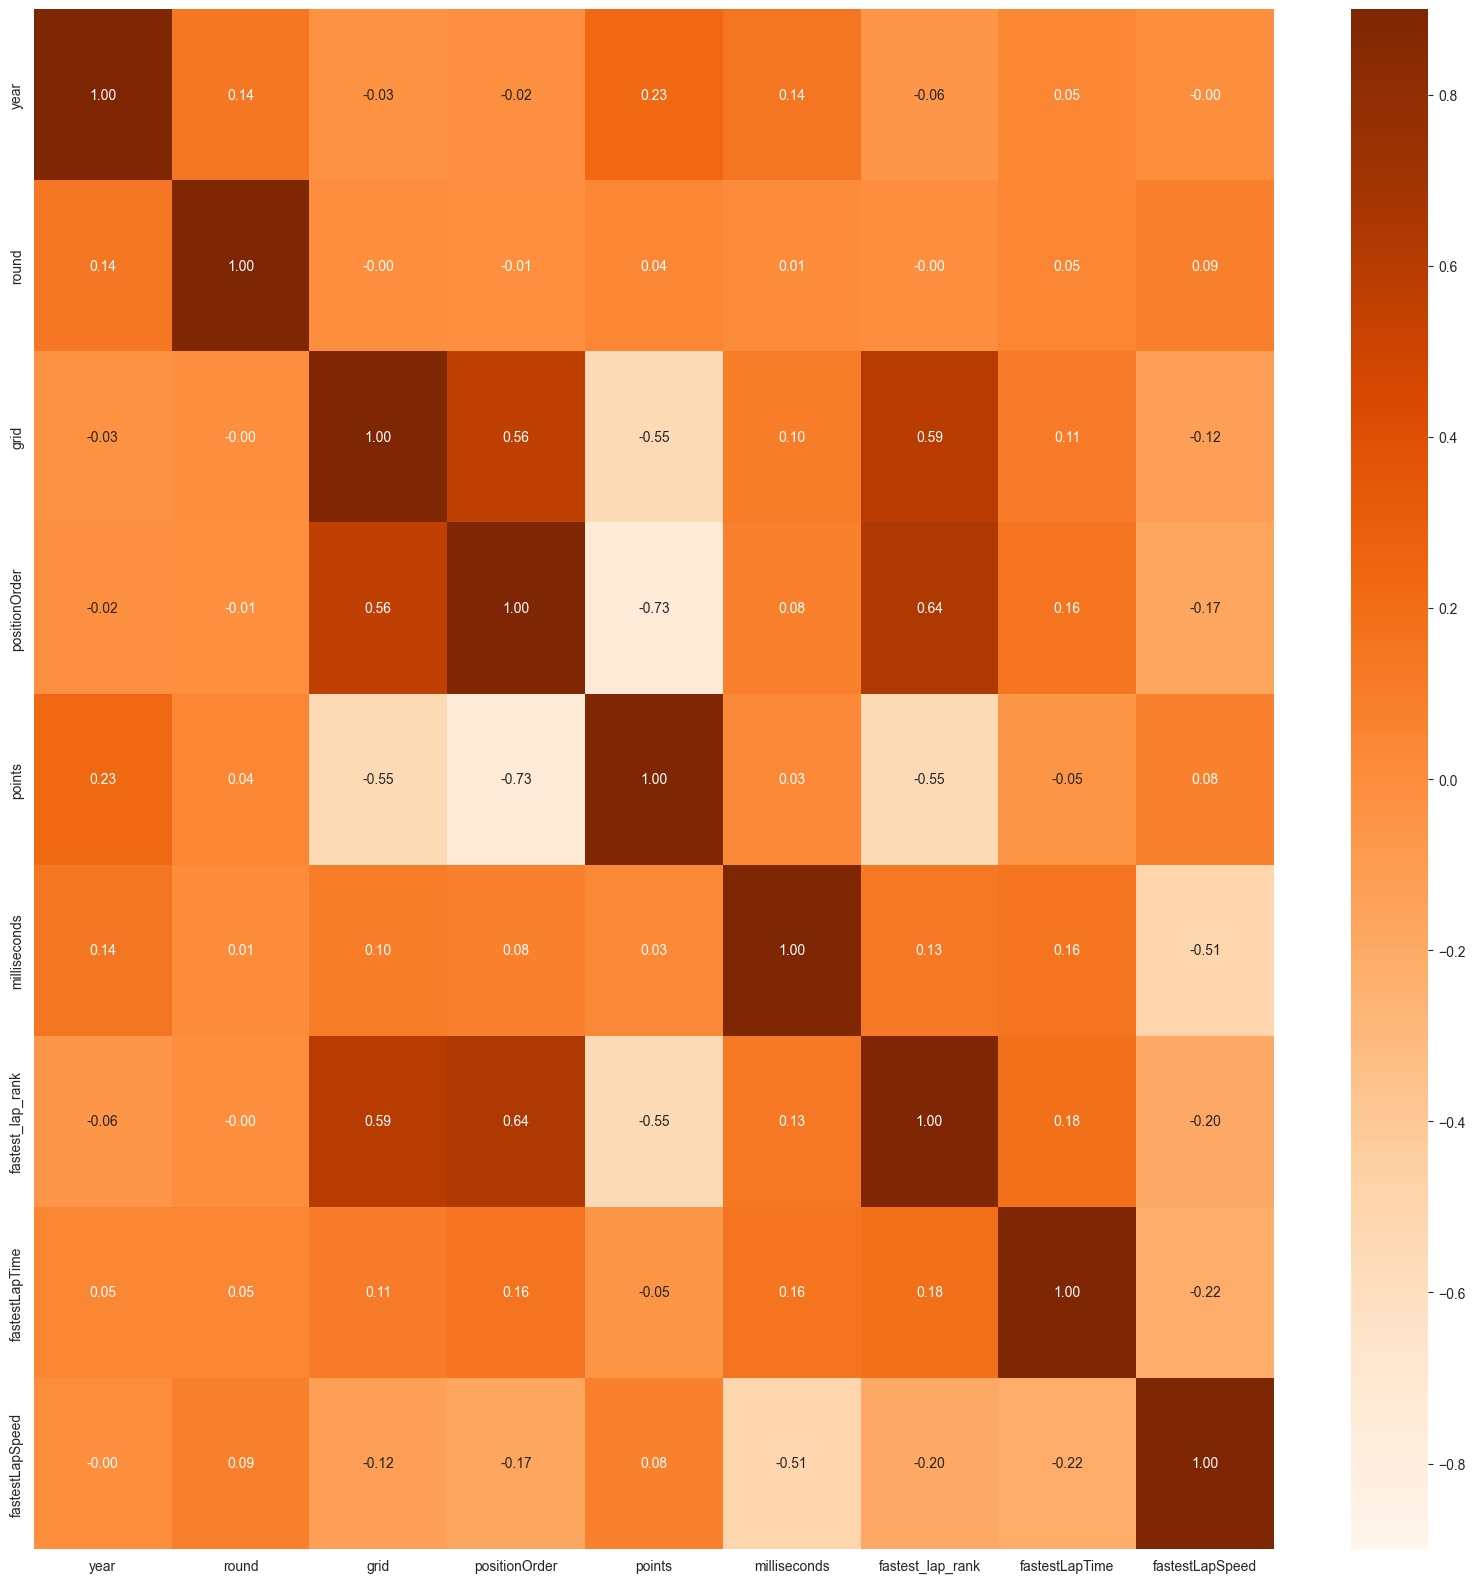

In [67]:
plt.figure(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, vmin=-0.9, vmax=0.9, cmap='Oranges', fmt='.2f');

En la matriz podemos ver las relaciones entre nuestras variables, las relaciones más destacables son:

- La relación entre 'grid' y 'points' y la relación entre 'positionOrder' y 'points' que ya hemos explicado previamente.

- La relación entre 'points' y 'year'. Esta relación no es especialmente fuerte, pero es curiosa, ya que tiene una valor relativamente elevado pese a que a priori podríamos pensar que no tendrían ninguna correlación. La correlación entre ambas se debe a que con el paso de los años se ha modificado (aumentado) la cantidad de puntos obtenida por los pilotos. Un ejemplo es que este año se ha aumentado el número de pilotos que puntúan de 8 a 10. Otro ejemplo es que hasta 2009 el primer clasificado obtenía 10 puntos, y ahora obtiene 25.

- También puede ser interesante la correlación entre "grid" y "positionOrder", ya que podríamos pensar que deberían tener una correlación más fuerte, pero esta relación varía mucho con respecto a cada circuito como explicaremos un poco más alante.

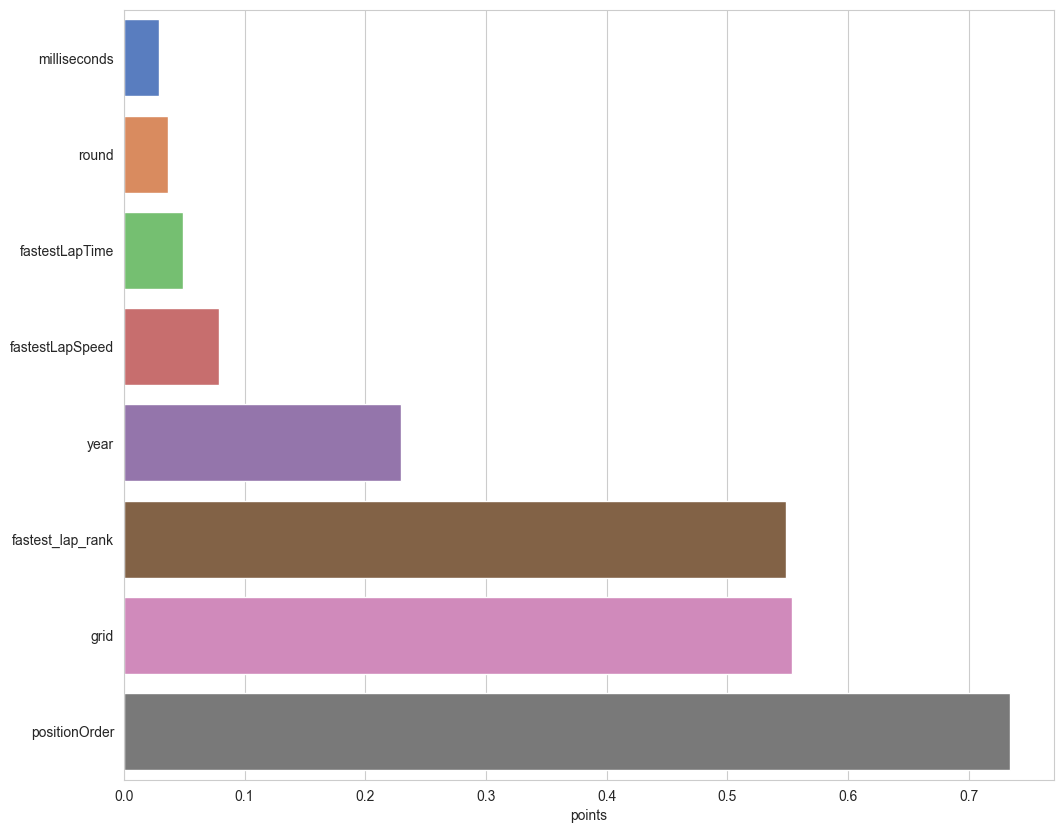

In [68]:
plt.figure(figsize=(12,10))
correlacion_puntos = df.corr()['points'].drop(['points'])

# Solo queremos ver la importancia de estos valores para obtener una victoria (sea positiva o negativa)
# así que tomamos valor absoluto
correlacion_puntos = np.absolute(correlacion_puntos)

correlacion_puntos = correlacion_puntos.sort_values(ascending=True)

color = sns.color_palette("muted", len(correlacion_puntos))
sns.barplot(y=correlacion_puntos.index, x=correlacion_puntos, palette=np.array(color)[correlacion_puntos.argsort().argsort()])

plt.show()

Dibujamos el diagrama de dispersión entre la variable 'points' y el resto de variables:

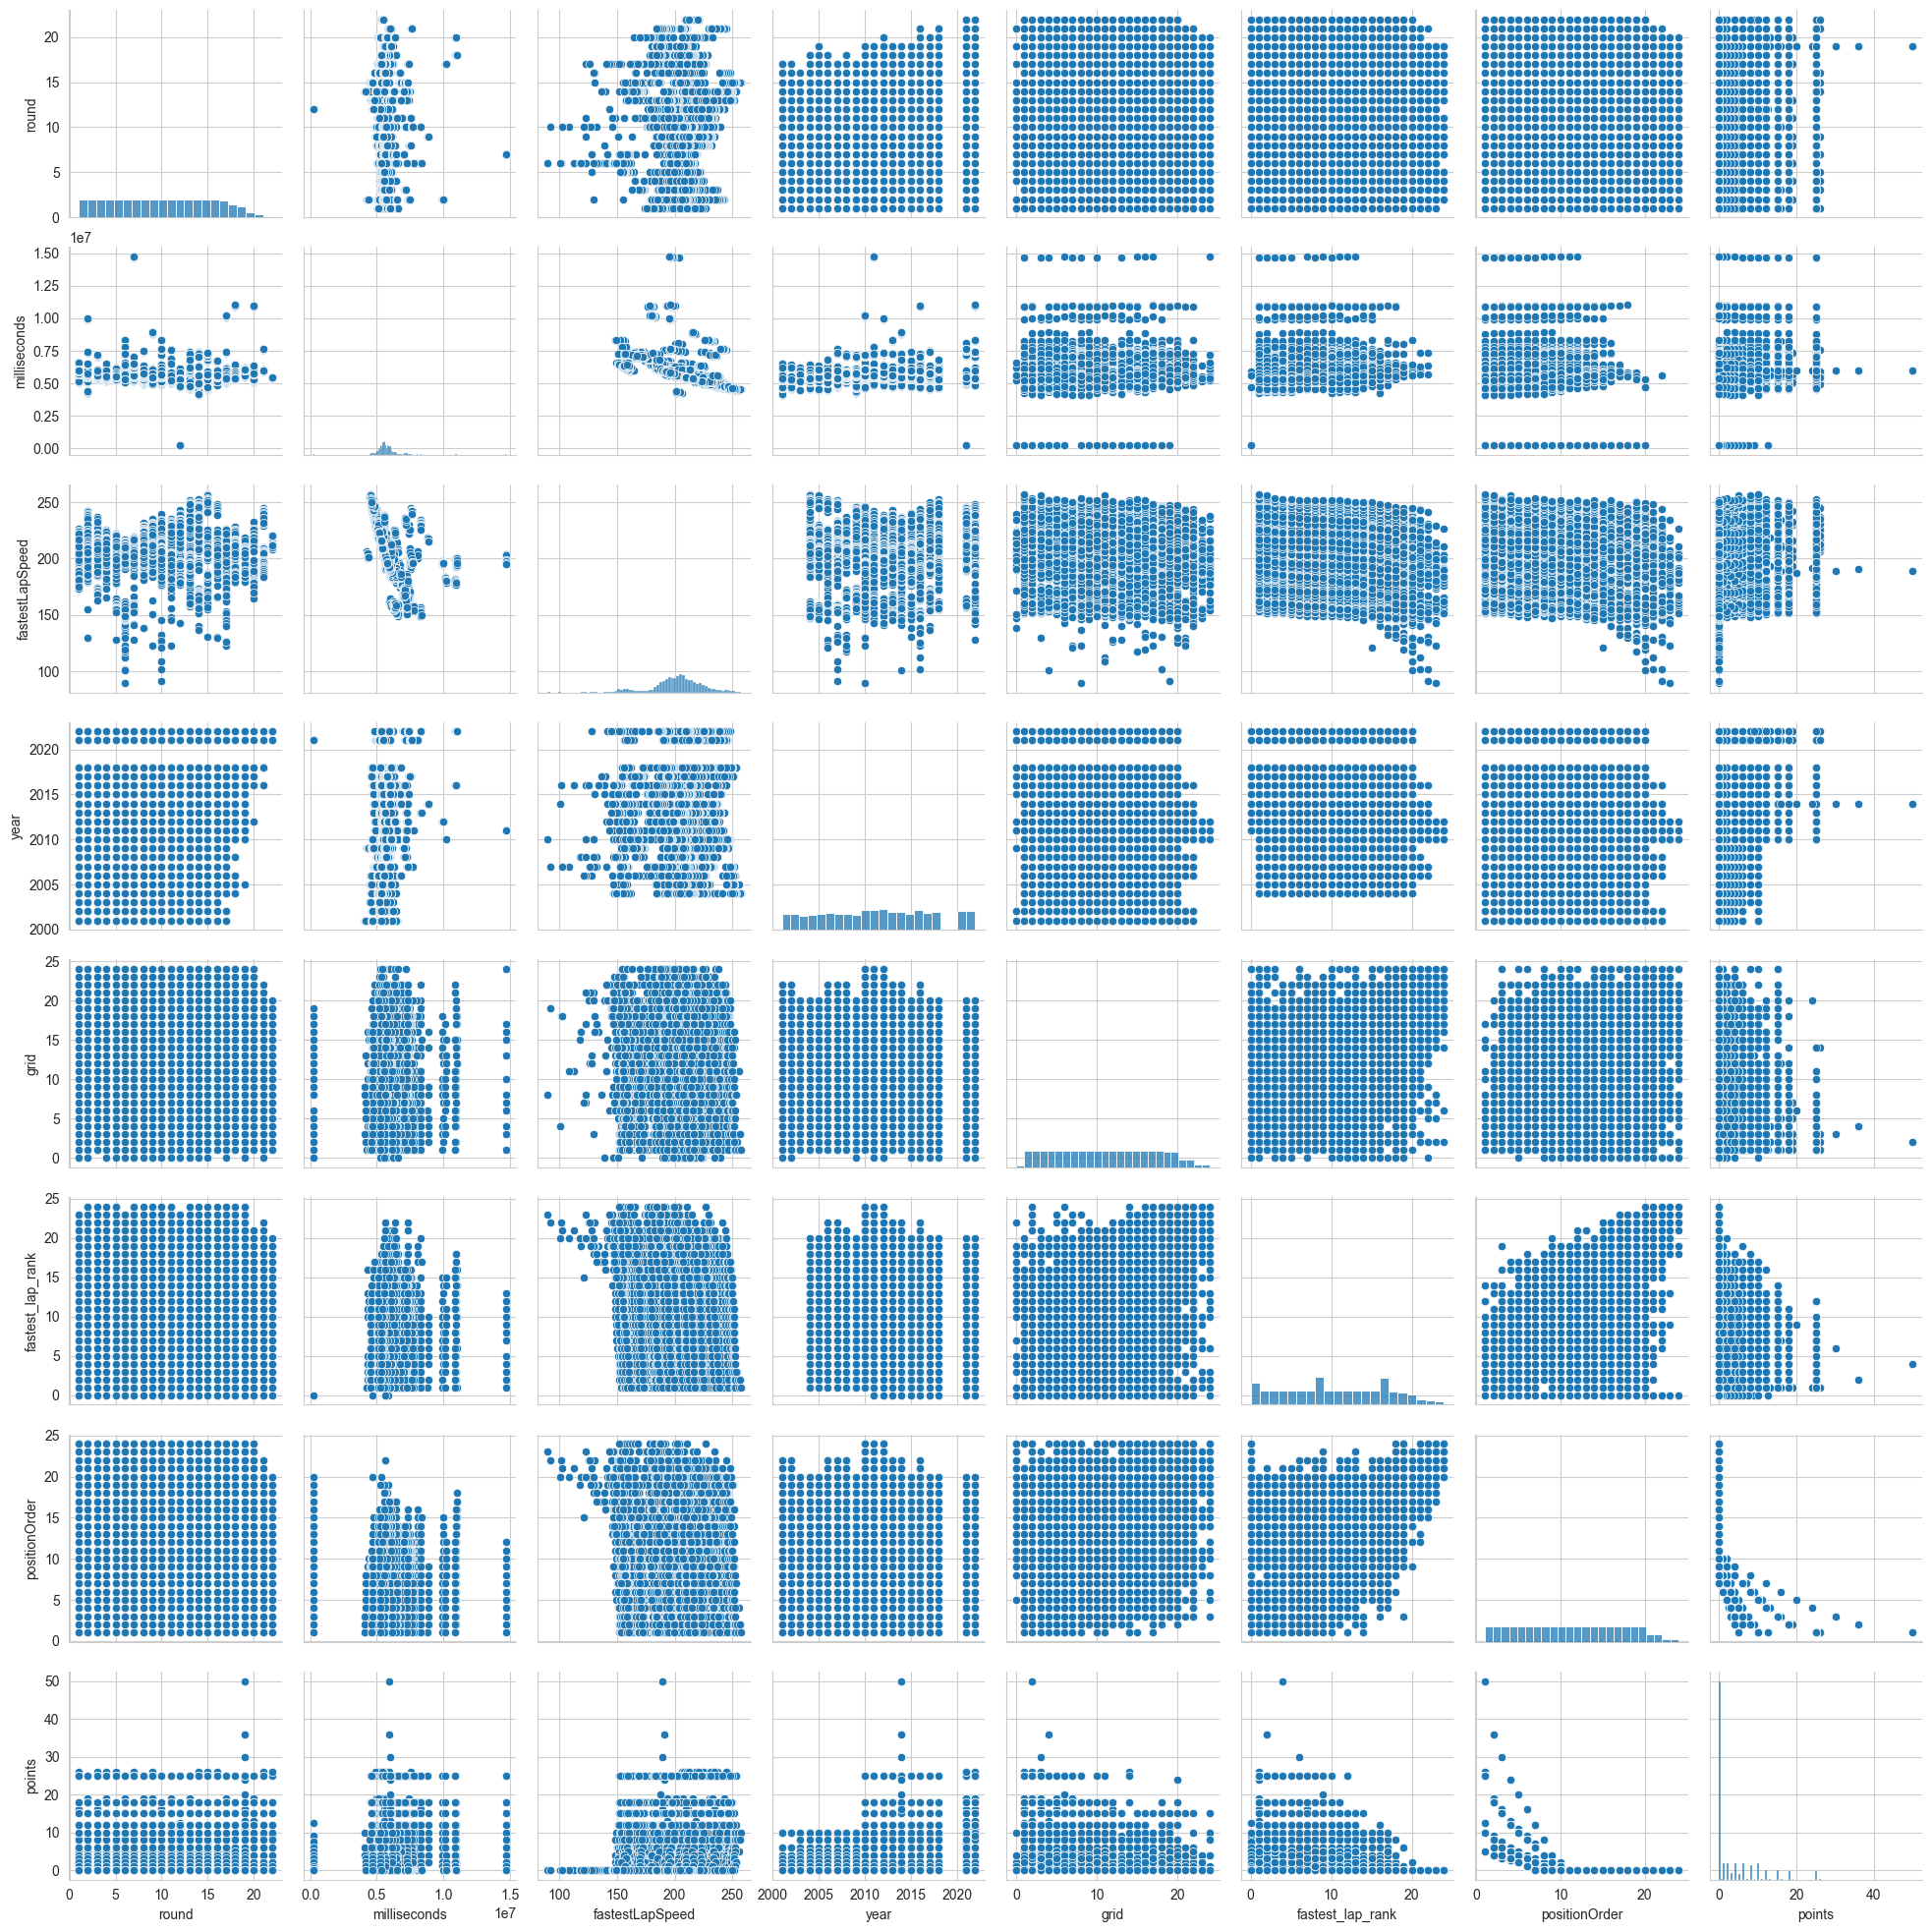

In [69]:
sns.pairplot(df[['round', 'milliseconds', 'fastestLapSpeed', 'year', 'grid', 'fastest_lap_rank', 'positionOrder', 'points']])

## Porcentaje victorias a lo largo de su carrera por años

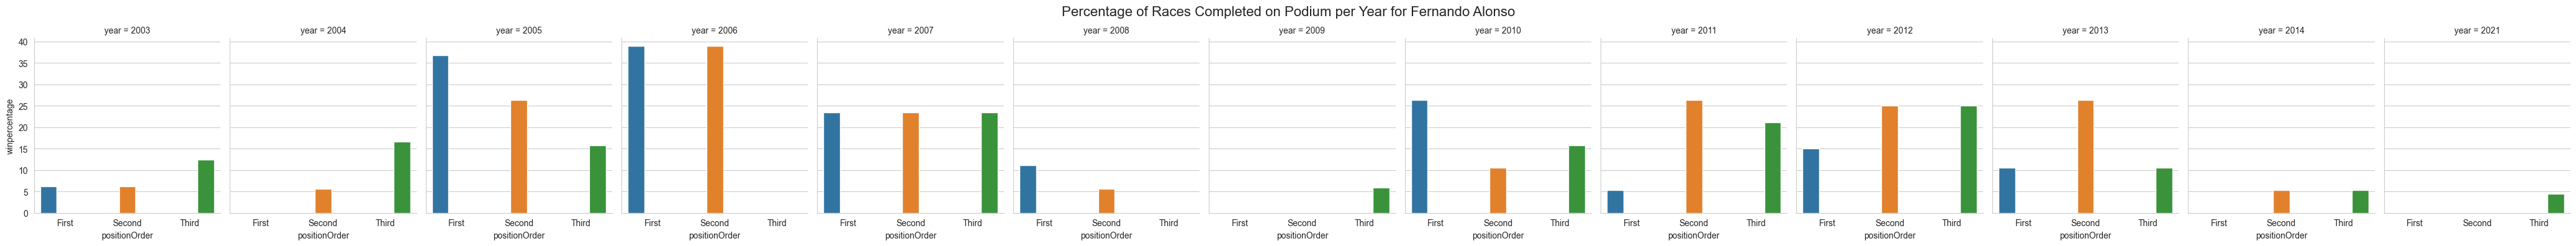

In [70]:
# group races by year and positionOrder for Fernando Alonso
fernando = df_alonso.groupby(['year', 'positionOrder']).size().reset_index(name='totalraces')

# calculate sum of races per year
fernando_sum = fernando.groupby(['year'])['totalraces'].sum().reset_index(name='sumbyyear')

# join both data sets to calculate the percentage of races per positionOrder per year
jraces = pd.merge(fernando, fernando_sum, on='year')
jraces['winpercentage'] = round((jraces['totalraces'] / jraces['sumbyyear']) * 100, 1)

# filter to get only podium wins
lraces = jraces.loc[jraces['positionOrder'] <= 3]

# rename positionOrder values to 'First', 'Second', 'Third'
lraces['positionOrder'].replace({1: 'First', 2: 'Second', 3: 'Third'}, inplace=True)

# create a grouped bar chart to show podium wins per year
sns.set_style('whitegrid')
sns.catplot(x='positionOrder', y='winpercentage', hue='positionOrder', col='year', 
            data=lraces, kind='bar', height=4, aspect=0.8 
            )
plt.subplots_adjust(top=0.85)
plt.suptitle('Percentage of Races Completed on Podium per Year for Fernando Alonso', fontsize=16)
plt.xlabel('')
plt.ylabel('Percentage Number of Wins')
plt.show()


En estas gráficas podemos observar el % de primeras, segundas y terceras posiciones a lo largo de la tratectoria de fernando, destacando los años en los que ha tenido un monoplaza competitivo como en 2005 y 2006 donde ganó el mundial, 2007 con Mclaren-Mercedes y los 4 años de ferrari.

Vamos a rescatar el df con todos los datos y hacer lo mismo que previamente para analizar todas las temporadas de alonso

In [71]:
df_data= df_data[df_data['year']!=2019]
df_data= df_data[df_data['year']!=2020]
df_data = df_data[df_data['year'] >= 2001]
df_alonso_data = df_data[df_data["driver"] == "alonso"]
df_alonso_data.head()

,grid,positionOrder,points,time,milliseconds,fastest_lap_rank,fastestLapTime,fastestLapSpeed,year,gp_name,round,driver,driver_nationality,constructor_name,constructor_nationality,status
3,11,4,5.0,+17.181,5707797,7,1:28.603,215.464,2008,Australian Grand Prix,1,alonso,Spanish,Renault,French,Finished
29,7,8,1.0,+1:10.041,5548596,10,1:36.288,207.240,2008,Malaysian Grand Prix,2,alonso,Spanish,Renault,French,Finished
53,10,10,0.0,+1:17.181,5544151,13,1:35.194,204.668,2008,Bahrain Grand Prix,3,alonso,Spanish,Renault,French,Finished
80,2,15,0.0,\N,\N,9,1:22.683,202.677,2008,Spanish Grand Prix,4,alonso,Spanish,Renault,French,Engine
93,7,6,3.0,+53.724,5263175,6,1:27.280,220.174,2008,Turkish Grand Prix,5,alonso,Spanish,Renault,French,Finished


## Victorias desde la pole position

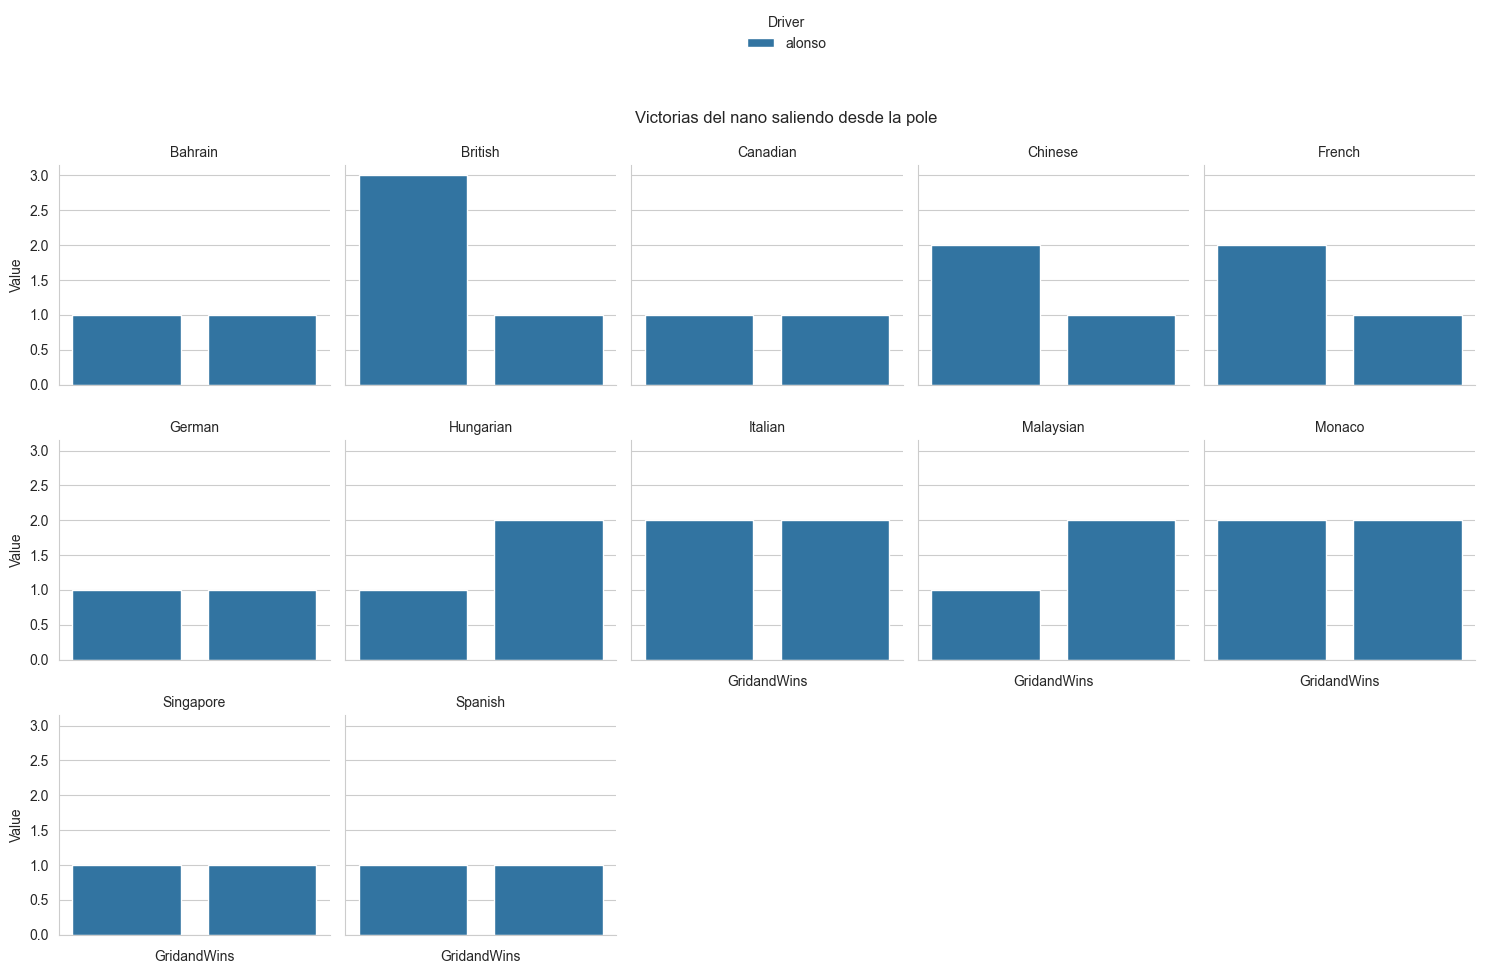

In [72]:
# Find the races where Fernando Alonso started at grid=1
alonso_grid = df_alonso_data[df_alonso_data['grid'] == 1]

# Group the data by raceName and calculate the number of times Alonso held first position
alonso_first_pos = alonso_grid.groupby(['gp_name', 'driver']).agg({'grid': 'sum'}) \
    .rename(columns={'grid': 'FirstPos'}).reset_index()

# Group the data by raceName and positionOrder and filter only for the races where Alonso won
alonso_wins = alonso_grid.groupby(['gp_name', 'positionOrder', 'driver']).agg({'positionOrder': 'count'}) \
    .rename(columns={'positionOrder': 'Wins'}).reset_index() \
    .query('positionOrder == 1')

# Merge the two dataframes on raceName and remove unnecessary columns
alonso_gp = pd.merge(alonso_first_pos, alonso_wins, on=['gp_name', 'driver'])
alonso_gp = alonso_gp[['gp_name', 'driver', 'FirstPos', 'Wins']]

# Remove the word 'Grand Prix' from the raceName
alonso_gp['gp_name'] = alonso_gp['gp_name'].str.replace(' Grand Prix', '')

# Reshape the data for plotting
alonso_plot = pd.melt(alonso_gp, id_vars=['gp_name', 'driver'], var_name='GridandWins', value_name='Value')
alonso_plot = alonso_plot.sort_values('gp_name')

# Create the FacetGrid
g = sns.FacetGrid(alonso_plot, col="gp_name", hue="driver", col_wrap=5, height=3)

# Define the plot function to create the bar plot
def plot_func(x, y, **kwargs):
    sns.barplot(x=x, y=y, **kwargs)

# Map the plot function to the FacetGrid
g.map(plot_func,"GridandWins", "Value")

# Set titles and labels
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.92)
g.fig.suptitle("Victorias del nano saliendo desde la pole", fontsize=12)
g.add_legend(title='Driver', fontsize=10, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)

# Rotate x-axis labels
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Show the plot
plt.show()


De esta gráfica podemos obtener algunas conclusiones como que no es necesario salir desde la pole position para ganar la carrera, aunque es cierto que hay circuitos en donde siempre que Alonso ha salido desde la primera posición ha ganado la carrera.

## Cómo ha terminado Fernando todas las carreras de su trayectoria

Text(0, 0.5, 'Status')

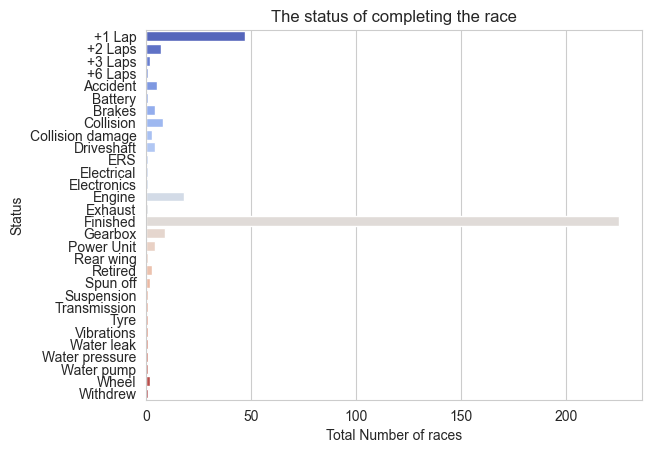

In [73]:
# group by status and count total
alonso_status = df_alonso_data.groupby('status').size().reset_index(name='total')

# plot bar chart
sns.barplot(x='total', y='status', data=alonso_status, palette='coolwarm')

# set plot labels and title
plt.title('The status of completing the race')
plt.xlabel('Total Number of races')
plt.ylabel('Status')

Podemos observar que Fernando ha sido uno de los pilotos más afectados por problemas mecánicos y accidentes de toda la fórmula uno. De sus 19 temporadas disputadas, contando una media de 20-22 carreras por temporada, podemos observar en la gráfica que ha perdido una temporada entera donde no ha podido terminar la carrera tan solo por fallos de motor. Vemos que Alonso no ha sido uno de los pilotos más beneficiados por la suerte.

In [74]:
df_data['raceId'] = races['raceId'] # create a new column with raceId values
df_data.head()

,grid,positionOrder,points,time,milliseconds,fastest_lap_rank,fastestLapTime,fastestLapSpeed,year,gp_name,round,driver,driver_nationality,constructor_name,constructor_nationality,status,raceId
0,1,1,10.0,1:34:50.616,5690616,2,1:27.452,218.300,2008,Australian Grand Prix,1,hamilton,British,McLaren,British,Finished,1.0
1,5,2,8.0,+5.478,5696094,3,1:27.739,217.586,2008,Australian Grand Prix,1,heidfeld,German,BMW Sauber,German,Finished,2.0
2,7,3,6.0,+8.163,5698779,5,1:28.090,216.719,2008,Australian Grand Prix,1,rosberg,German,Williams,British,Finished,3.0
3,11,4,5.0,+17.181,5707797,7,1:28.603,215.464,2008,Australian Grand Prix,1,alonso,Spanish,Renault,French,Finished,4.0
4,3,5,4.0,+18.014,5708630,1,1:27.418,218.385,2008,Australian Grand Prix,1,kovalainen,Finnish,McLaren,British,Finished,5.0


## Victorias de todos los pilotos de los circuitos más famosos 

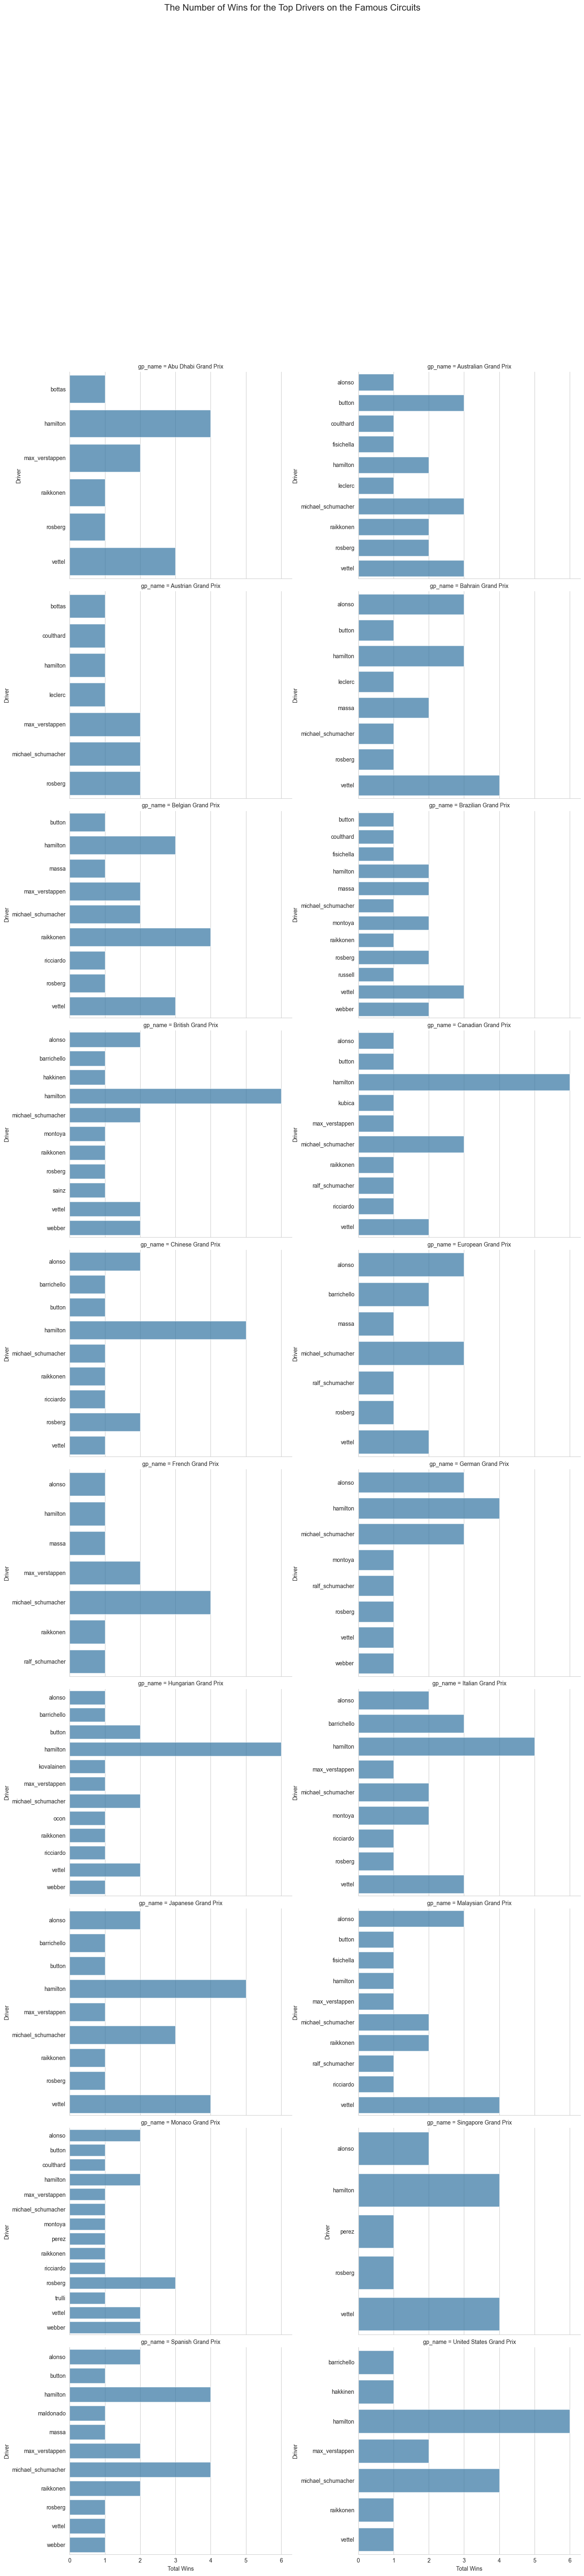

In [75]:
# Filtrar los circuitos con más de 40 carreras
count_circuits = df_data.groupby('gp_name').size().reset_index(name='count')
famous_circuits = count_circuits[count_circuits['count'] > 200]['gp_name']

# Contar el número de victorias para cada piloto en los circuitos más famosos
famous_wins = df_data[df_data['gp_name'].isin(famous_circuits) & (df_data['positionOrder'] == 1)]
famous_win_counts = famous_wins.groupby(['gp_name', 'driver']).size().reset_index(name='total')

# Crear el gráfico de barras con la paleta personalizada
g = sns.FacetGrid(famous_win_counts, col='gp_name', col_wrap=2, sharey=False, height=6, aspect=1.2)
g.map(sns.barplot, 'total', 'driver', alpha=.7)
g.set(xlabel='Total Wins', ylabel='Driver')
g.fig.subplots_adjust(top=0.9, wspace=0.3)
g.fig.suptitle('The Number of Wins for the Top Drivers on the Famous Circuits', fontsize=16, y=1.05)

plt.show()




Con estos gráficos podemos sacar distintas conclusiones. Podemos ver qué circuitos han domindado ciertos pilotos, como Lewis Hamilton, donde tiene entre 4-5 victorias en algunos circuitos debido a la época dominante que tuvo con Mercedes. también observamos qué circuitos son más propensos a tener distintos ganadores a lo largo de la historia, como Mónaco, que encontramos una gran variedad de pilotos que tan solo han ganado una vez y nadie domina el circuito. Por último podemos ver cuáles son los grandes premios que se han incorporado a lo largo de la historia o han dejado de celebrarse por el nº de ganadores.

## Evolución de los puntos en los años 2005, 2006 y 2010

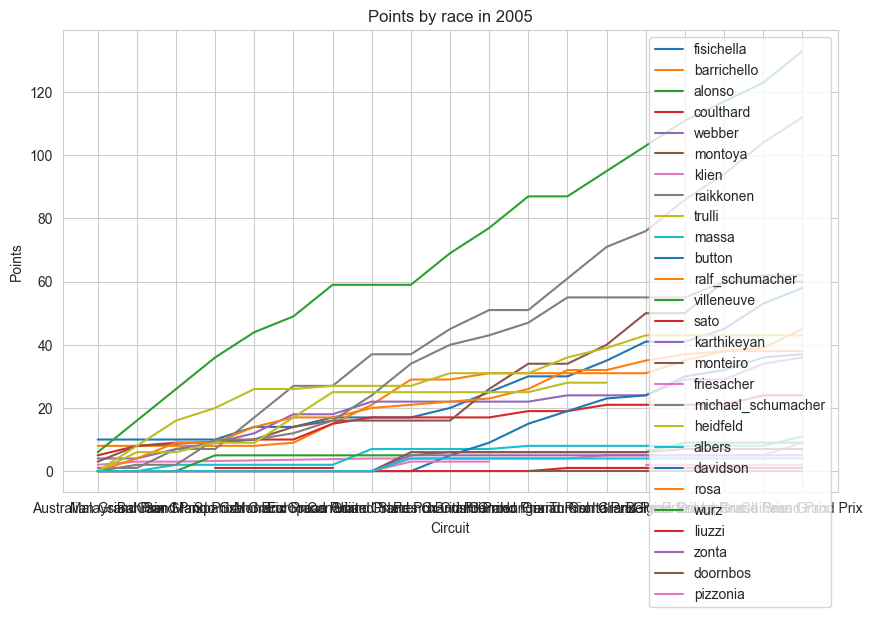

In [76]:
# Seleccionar solo los datos del año 2005
df_year = df_data[df_data['year'] == 2005]

# Seleccionar solo los conductores únicos del año 2005
drivers = df_year['driver'].unique()

# Crear una nueva columna con la suma acumulada de puntos por carrera para cada conductor
df_year['pointsum'] = df_year.groupby(['driver'])['points'].cumsum()

# Filtrar los datos solo para los conductores seleccionados
df_filtered = df_year[df_year['driver'].isin(drivers)]

# Configurar los parámetros del gráfico
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Circuit')
ax.set_ylabel('Points')
ax.set_title('Points by race in 2005')

# Iterar a través de los conductores seleccionados y trazar una línea para cada uno
for driver in drivers:
    driver_data = df_filtered[df_filtered['driver'] == driver]
    ax.plot(driver_data['gp_name'], driver_data['pointsum'], label=driver)

# Agregar una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


Podemos ver que en la temporada 2005 hubo una clara dominación por parte del piloto asturiano, donde consiguió el mundial sin grandes disputas, a pesar del acercamiento de Schumacher en las últimas carreras

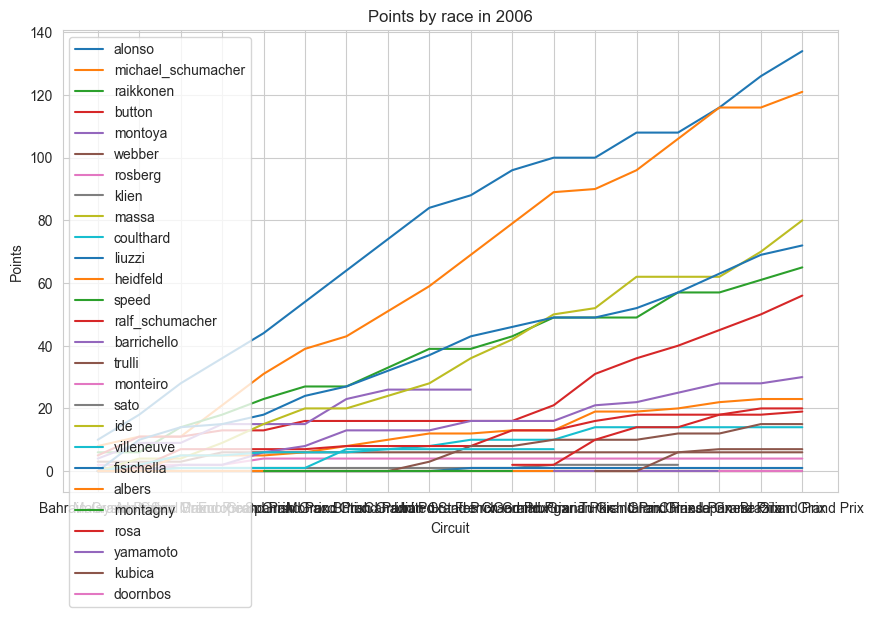

In [77]:
# Seleccionar solo los datos del año 2005
df_year = df_data[df_data['year'] == 2006]

# Seleccionar solo los conductores únicos del año 2005
drivers = df_year['driver'].unique()

# Crear una nueva columna con la suma acumulada de puntos por carrera para cada conductor
df_year['pointsum'] = df_year.groupby(['driver'])['points'].cumsum()

# Filtrar los datos solo para los conductores seleccionados
df_filtered = df_year[df_year['driver'].isin(drivers)]

# Configurar los parámetros del gráfico
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Circuit')
ax.set_ylabel('Points')
ax.set_title('Points by race in 2006')

# Iterar a través de los conductores seleccionados y trazar una línea para cada uno
for driver in drivers:
    driver_data = df_filtered[df_filtered['driver'] == driver]
    ax.plot(driver_data['gp_name'], driver_data['pointsum'], label=driver)

# Agregar una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


En este año, podemos ver cómo hasta las 2 últimas carreras no se decidió el campeón del mundial de pilotos, llegando los 2 grandes rivales, Alonso y Schumacher empatados a puntos.

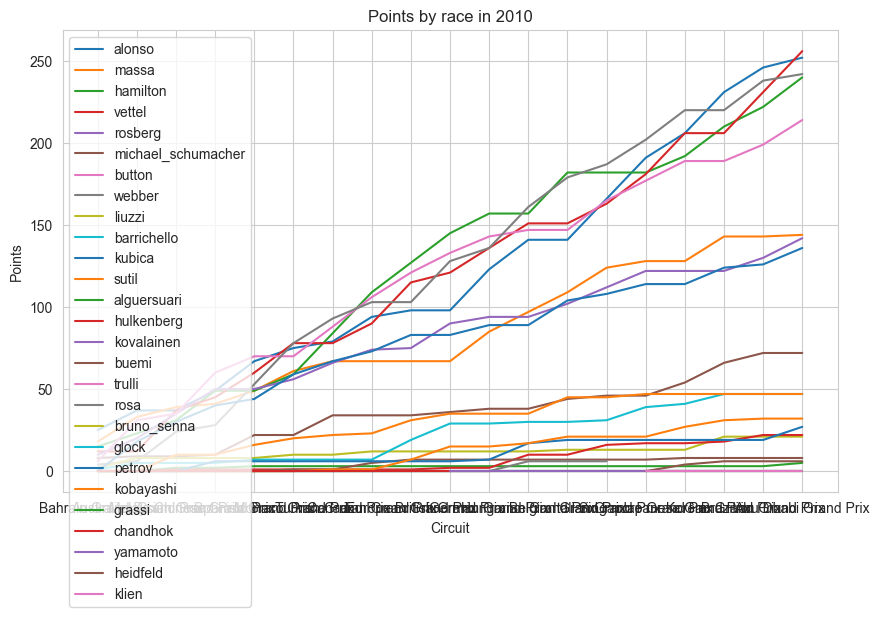

In [78]:
# Seleccionar solo los datos del año 2005
df_year = df_data[df_data['year'] == 2010]

# Seleccionar solo los conductores únicos del año 2005
drivers = df_year['driver'].unique()

# Crear una nueva columna con la suma acumulada de puntos por carrera para cada conductor
df_year['pointsum'] = df_year.groupby(['driver'])['points'].cumsum()

# Filtrar los datos solo para los conductores seleccionados
df_filtered = df_year[df_year['driver'].isin(drivers)]

# Configurar los parámetros del gráfico
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Circuit')
ax.set_ylabel('Points')
ax.set_title('Points by race in 2010')

# Iterar a través de los conductores seleccionados y trazar una línea para cada uno
for driver in drivers:
    driver_data = df_filtered[df_filtered['driver'] == driver]
    ax.plot(driver_data['gp_name'], driver_data['pointsum'], label=driver)

# Agregar una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()

En la temporada 2020, observamos cómo fue un mundial que hasta 4 pilotos distintos pudieron haberse alzado con el título en la última carrera, siendo Vettel el campeón de ese año.

In [79]:
famous_win_counts.head()

,gp_name,driver,total
0,Abu Dhabi Grand Prix,bottas,1
1,Abu Dhabi Grand Prix,hamilton,4
2,Abu Dhabi Grand Prix,max_verstappen,2
3,Abu Dhabi Grand Prix,raikkonen,1
4,Abu Dhabi Grand Prix,rosberg,1


Enseñamos el dataFrame solo con Fernando Alonso:

In [80]:
df_alonso.head()

,year,gp_name,round,driver,constructor_name,grid,positionOrder,points,time,milliseconds,fastest_lap_rank,fastestLapTime,fastestLapSpeed,driver_nationality,constructor_nationality
25408,2022,Bahrain Grand Prix,1,alonso,Alpine F1 Team,8,9,2.0,+22.390,5875974.0,10.0,136.733,201.412,Spanish,French
25435,2022,Saudi Arabian Grand Prix,2,alonso,Alpine F1 Team,7,16,0.0,NaN,NaN,12.0,133.831,236.876,Spanish,French
25456,2022,Australian Grand Prix,3,alonso,Alpine F1 Team,10,17,0.0,NaN,NaN,2.0,120.846,235.024,Spanish,French
25478,2022,Emilia Romagna Grand Prix,4,alonso,Alpine F1 Team,9,19,0.0,NaN,NaN,19.0,139.685,177.282,Spanish,French
25490,2022,Miami Grand Prix,5,alonso,Alpine F1 Team,11,11,0.0,+37.128,5701386.0,13.0,133.331,208.753,Spanish,French


In [81]:
# Verificar si las columnas están presentes en df_alonso
columns_to_drop = ['driver', 'year', 'round', 'gp_name', 'constructor_name', 'time', 'driver_nationality', 'constructor_nationality']
columns_to_drop = [col for col in columns_to_drop if col in df_alonso.columns]

# Eliminar las columnas del DataFrame
df_alonso.drop(columns_to_drop, axis=1, inplace=True)


In [82]:
df_alonso.head()

,grid,positionOrder,points,milliseconds,fastest_lap_rank,fastestLapTime,fastestLapSpeed
25408,8,9,2.0,5875974.0,10.0,136.733,201.412
25435,7,16,0.0,NaN,12.0,133.831,236.876
25456,10,17,0.0,NaN,2.0,120.846,235.024
25478,9,19,0.0,NaN,19.0,139.685,177.282
25490,11,11,0.0,5701386.0,13.0,133.331,208.753


In [83]:
df_alonso.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 25408 to 2918
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   grid              358 non-null    int64  
 1   positionOrder     358 non-null    int64  
 2   points            358 non-null    float64
 3   milliseconds      225 non-null    float64
 4   fastest_lap_rank  322 non-null    float64
 5   fastestLapTime    312 non-null    float64
 6   fastestLapSpeed   312 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 22.4 KB


## Búsqueda del mejor modelo de predicción

Separamos nuestros datos en los conjuntos de entrenamiento (80%) y test(20%). Usaremos estos datos sin escalar para nuestros modelos de K-vecinos, árbol de decisión y NB.

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_alonso = df_alonso.fillna(df_alonso.median())

df_alonso_redes = df_alonso

# Dividir el conjunto de datos en características de entrada (X) y variable de salida (y)
X = df_alonso.drop(['points'], axis=1)
y = df_alonso['points'].astype(int)

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



### Redes Neuronales

Escalamos los datos solo para el modelo de redes neuronales:

In [85]:
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense

warnings.filterwarnings('ignore')

# Preprocess the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_alonso_redes), columns=df_alonso_redes.columns)

# Dividir el conjunto de datos en características de entrada (X) y variable de salida (y)
X_scaled = df_scaled.drop(['points'], axis=1)
y_scaled = df_scaled['points'].astype(int)

# Dividir el conjunto de datos en conjuntos de entrenamiento y prueba
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Define the model architecture
def create_model():
    model = Sequential()
    model.add(Dense(100, activation='sigmoid', input_dim=X.shape[1]))
    model.add(Dense(50, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Crear el modelo de KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32, verbose=0)

# Calcular el score de validación cruzada
scores = cross_val_score(model, X_scaled, y_scaled, cv=5)

# Imprimir los resultados
print("Precisión promedio: {:.2f}".format(scores.mean()))
print("Desviación estándar: {:.2f}".format(scores.std()))

# Train the model on the entire training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the performance on the test set
mse = mean_squared_error(y_test, y_pred)
print("Test mean squared error: {:.2f}".format(mse))

print("Predicted values: ", y_pred)



Precisión promedio: 0.97
Desviación estándar: 0.05
3/3 [==============================] - 0s 1ms/step
Test mean squared error: 38.90
Predicted values:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]


los resultados de precisión y desviación estándar que obtenemos son bastante malos ya que la predicción de la clasificación final de Fernando Alonso al terminar la temporada 2023 utilizando redes neuronales es un problema complejo y desafiante que requeriría una gran cantidad de datos y recursos computacionales, así como un enfoque cuidadosamente diseñado para entrenar y ajustar el modelo de redes neuronales.

### Gaussian Naive Bayes (NB)


In [86]:
from sklearn.metrics import confusion_matrix

# Crear y entrenar el modelo Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predecir las etiquetas en el conjunto de prueba
y_pred = gnb.predict(X_test)

# Otros valores que nos serán útiles más tarde
p_nb = np.around(precision_score(y_pred, y_test, average = None), decimals=3)
r_nb = np.around(recall_score(y_pred, y_test, average = None), decimals=3)
f1_nb = np.around(f1_score(y_pred, y_test, average = None), decimals=3)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo Gaussian Naive Bayes: {:.2f}".format(accuracy))
print(accuracy)
print("La matriz de confusión para el modelo NB es: \n",confusion_matrix(y_test, y_pred))



Precisión del modelo Gaussian Naive Bayes: 0.46
0.4583333333333333
La matriz de confusión para el modelo NB es: 
 [[30  0  0  1  0  1  0  0  0  0  0  1]
 [ 2  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  2  0  0  0  0]
 [ 2  0  0  1  0  0  0  2  0  0  0  0]
 [ 1  0  0  0  0  0  1  0  0  0  0  0]
 [ 6  0  0  0  0  1  1  0  0  0  0  0]
 [ 3  0  0  1  0  0  1  1  0  0  0  0]
 [ 3  0  0  1  0  1  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  1  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0]]


Podemos ver como el modelo NB es el que pero resultados nos da. Su matriz de confusión es bastante mala ya que predice erróneamente como 0 puntos en muchas ocasiones y en ninguna ocasión predice acertadamente un número elevado de puntos. También es destacable su bajo valor de precisión.

### Algoritmo K-Neighbours


In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

grid = {"n_neighbors":np.arange(1,10)}
clf_knn = GridSearchCV(knn, grid, n_jobs=-1)
clf_knn.fit(X_train,y_train)

y_pred = clf_knn.predict(X_test)
clf_knn.best_estimator_

KNeighborsClassifier(n_neighbors=9)

Usando el código comentado arriba, logramos obtener que el número óptimo de vecinos para este problema es 9. 

In [88]:
knn = KNeighborsClassifier(n_neighbors=9)

knn.fit(X_train,y_train)

y_pred = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred)

# Otros valores que nos serán útiles más tarde
p_knn = np.around(precision_score(y_pred, y_test, average = None), decimals=3)
r_knn = np.around(recall_score(y_pred, y_test, average = None), decimals=3)
f1_knn = np.around(f1_score(y_pred, y_test, average = None), decimals=3)

print(acc_knn)
print("La matriz de confusión para el modelo K-Neighbours es: \n",confusion_matrix(y_test, y_pred))


0.5
La matriz de confusión para el modelo K-Neighbours es: 
 [[29  0  0  2  0  2  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  0  0  0  1  1  0  0  0  0]
 [ 2  0  0  0  0  1  0  2  0  0  0  0]
 [ 0  0  0  0  0  1  0  1  0  0  0  0]
 [ 2  0  0  0  2  2  0  2  0  0  0  0]
 [ 1  0  0  0  0  2  2  1  0  0  0  0]
 [ 0  0  0  0  0  0  2  3  0  0  0  0]
 [ 1  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  1  0  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0  0  0]]


Este modelo también observamos que da un valor de precisión bastante pobre (solo un 50%). Su matriz de confusión también es bastante pobre, pero al menos predice correctamente algunos de los valores medios de puntos. También es destacable que este modelo no predice, en tantas ocasiones como el NB, erróneamente como 0 puntos.

### Árboles de decisión

Primero intentamos calcular la profundidad óptima para nuestro árbol.

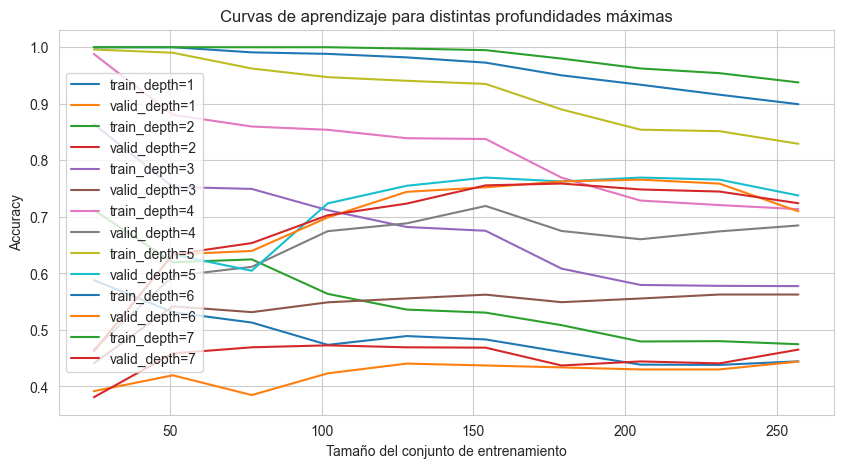

In [89]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import learning_curve
# Lista con los valores de profundidad máxima que vamos a probar
max_depths = [1, 2, 3, 4, 5, 6 ,7]

# Calculamos las curvas de aprendizaje para cada valor de profundidad máxima
train_scores, valid_scores = [], []
for max_depth in max_depths:
    clf = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    train_sizes, train_score, valid_score = learning_curve(clf, X_train, y_train, cv=10, train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores.append(np.mean(train_score, axis=1))
    valid_scores.append(np.mean(valid_score, axis=1))

# Pintamos las curvas de aprendizaje
plt.figure(figsize=(10, 5))
for i in range(len(max_depths)):
    plt.plot(train_sizes, train_scores[i], label='train_depth={}'.format(max_depths[i]))
    plt.plot(train_sizes, valid_scores[i], label='valid_depth={}'.format(max_depths[i]))
plt.legend()
plt.title('Curvas de aprendizaje para distintas profundidades máximas')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Accuracy')
plt.show()

Observando las curvas de aprendizaje, podemos notar que a medida que aumenta la profundidad del árbol, la precisión del modelo en el conjunto de entrenamiento aumenta rápidamente hasta alcanzar una precisión máxima, mientras que en el conjunto de validación, la precisión aumenta con una pendiente más suave, alcanzando un máximo y luego disminuyendo ligeramente.

El sobreajuste comienza a aparecer para valores de profundidad del árbol mayores a 5, donde la precisión en el conjunto de entrenamiento continúa mejorando, mientras que la precisión en el conjunto de validación comienza a disminuir.

Por lo tanto, un valor adecuado para el parámetro de profundidad del árbol podría ser 5, donde la precisión en el conjunto de validación alcanza un máximo y el sobreajuste aún no se ha convertido en un problema significativo.

De todas formas, mostraremos también la prundidad 3 y 4 para comprobar valores.

In [90]:
tree_3 = DecisionTreeClassifier(max_depth=3,random_state=7)

tree_3.fit(X_train,y_train)

y_pred = tree_3.predict(X_test)
acc_tree_3 = accuracy_score(y_pred, y_test)

# Otros valores que nos serán útiles más tarde
p_t3 = np.around(precision_score(y_pred, y_test, average = None), decimals=3)
r_t3 = np.around(recall_score(y_pred, y_test, average = None), decimals=3)
f1_t3 = np.around(f1_score(y_pred, y_test, average = None), decimals=3)

print(acc_tree_3)
print("La matriz de confusión para el árbol de decisión con profundidad 3 es: \n",confusion_matrix(y_test, y_pred))

0.6388888888888888
La matriz de confusión para el árbol de decisión con profundidad 3 es: 
 [[31  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  3  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  3  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0]]


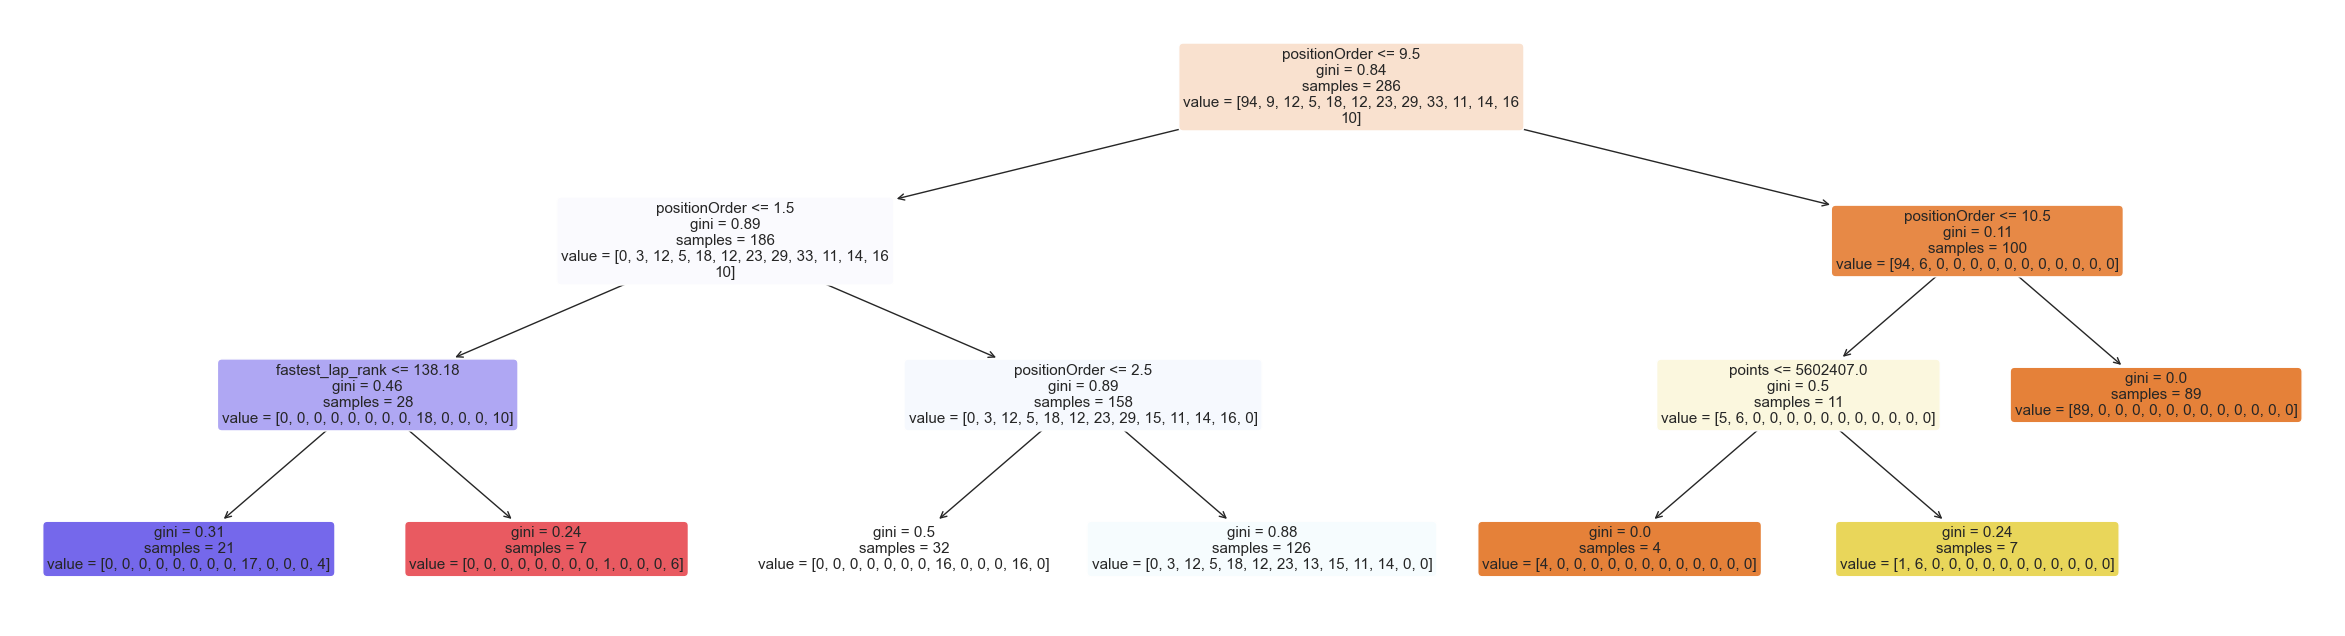

In [92]:
plt.figure(figsize=(30,8))
arbol_3 = plot_tree(tree_3, feature_names = df_scaled.columns, rounded = True, 
                    proportion = False, precision = 2, filled = True)


In [93]:
tree_4 = DecisionTreeClassifier(max_depth=4,random_state=7)

tree_4.fit(X_train,y_train)

y_pred = tree_4.predict(X_test)
acc_tree_4 = accuracy_score(y_pred, y_test)

# Otros valores que nos serán útiles más tarde
p_t4 = np.around(precision_score(y_pred, y_test, average = None), decimals=3)
r_t4 = np.around(recall_score(y_pred, y_test, average = None), decimals=3)
f1_t4 = np.around(f1_score(y_pred, y_test, average = None), decimals=3)

print(acc_tree_4)
print("La matriz de confusión para el árbol de decisión con profundidad 4 es: \n",confusion_matrix(y_test, y_pred))

0.6388888888888888
La matriz de confusión para el árbol de decisión con profundidad 4 es: 
 [[31  1  0  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  4  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  4  0  0  0  0  0  4  0  0]
 [ 0  0  0  3  0  0  3  0  0  0  0  0]
 [ 0  0  0  2  0  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0]]


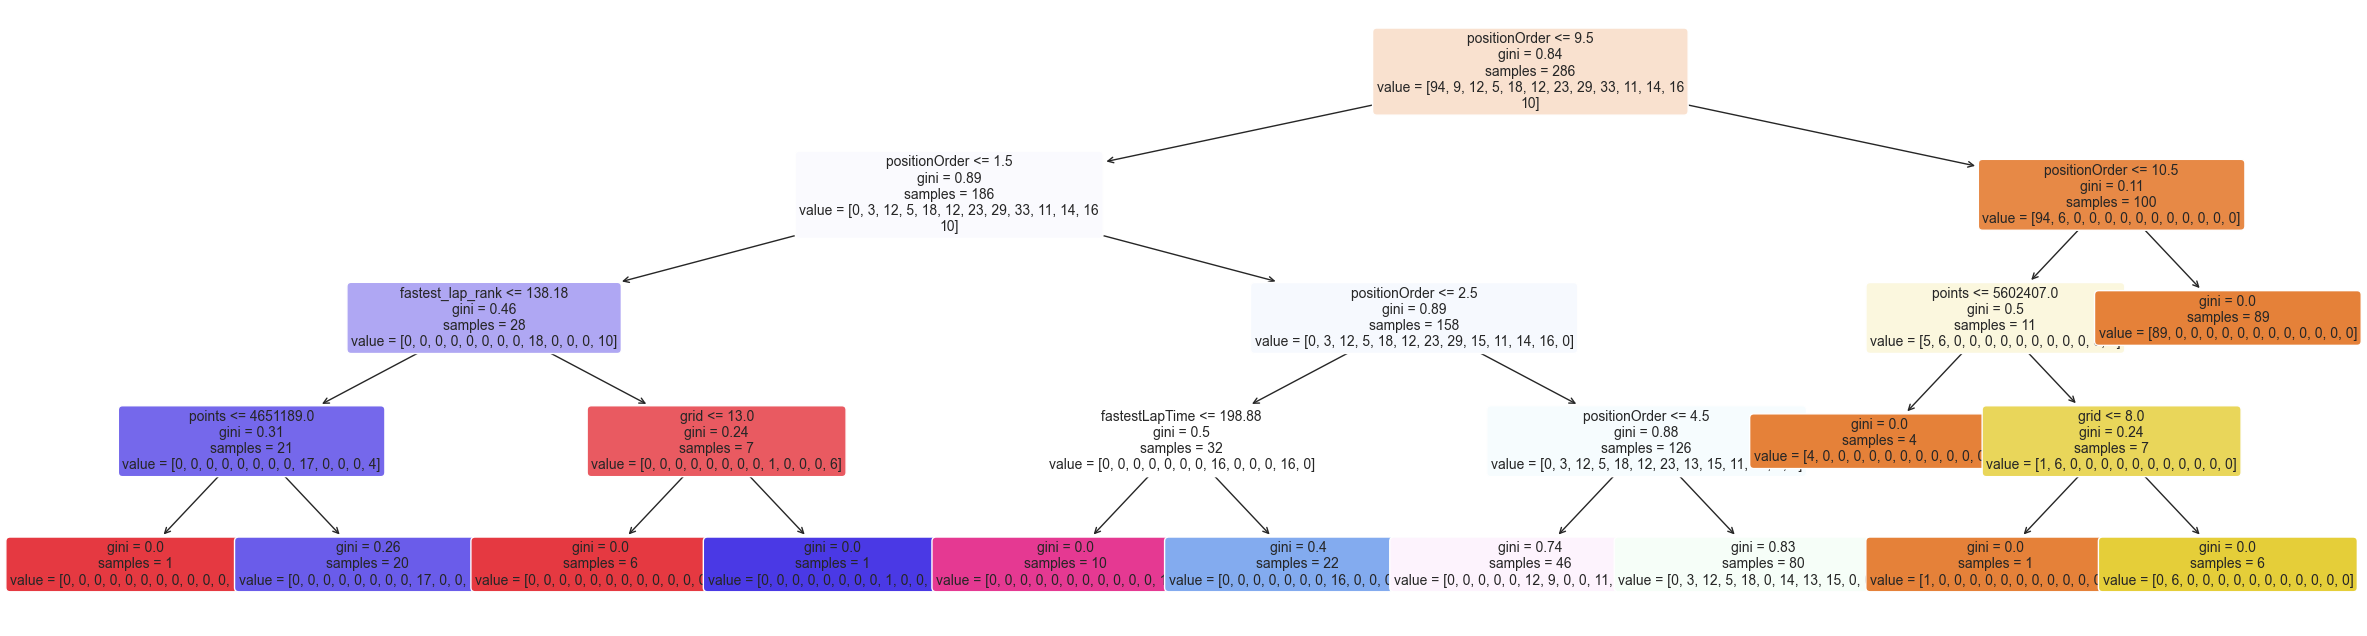

In [95]:
plt.figure(figsize=(30,8))
arbol_4 = plot_tree(tree_4, feature_names = df_scaled.columns, rounded = True, 
                    proportion = False, precision = 2, filled = True, fontsize=10)

In [96]:
tree_5 = DecisionTreeClassifier(max_depth=5,random_state=7)

tree_5.fit(X_train,y_train)

y_pred = tree_5.predict(X_test)
acc_tree_5 = accuracy_score(y_test, y_pred)

# Otros valores que nos serán útiles más tarde
p_t5 = np.around(precision_score(y_pred, y_test, average = None), decimals=3)
r_t5 = np.around(recall_score(y_pred, y_test, average = None), decimals=3)
f1_t5 = np.around(f1_score(y_pred, y_test, average = None), decimals=3)

print(acc_tree_5)
print("La matriz de confusión para el árbol de decisión con profundidad 5 es: \n",confusion_matrix(y_test, y_pred))


0.6944444444444444
La matriz de confusión para el árbol de decisión con profundidad 5 es: 
 [[31  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  1  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  2  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  4  0  0]
 [ 0  0  0  0  0  3  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  1  0  0  0  0]]


Vemos que con este modelo nuestra precisión ha mejorado bastante, llegando hasta casi el 70%. Además su matriz de confusión es bastante mejor que las demás pues en este caso no predice erróneamente como 0 puntos nunca, y aún más importante, es el único modelo que predice acertadamente valores altos de puntos, como podemos ver en la penúltima (15 puntos) y antepenúltima (18 puntos) filas/columnas.

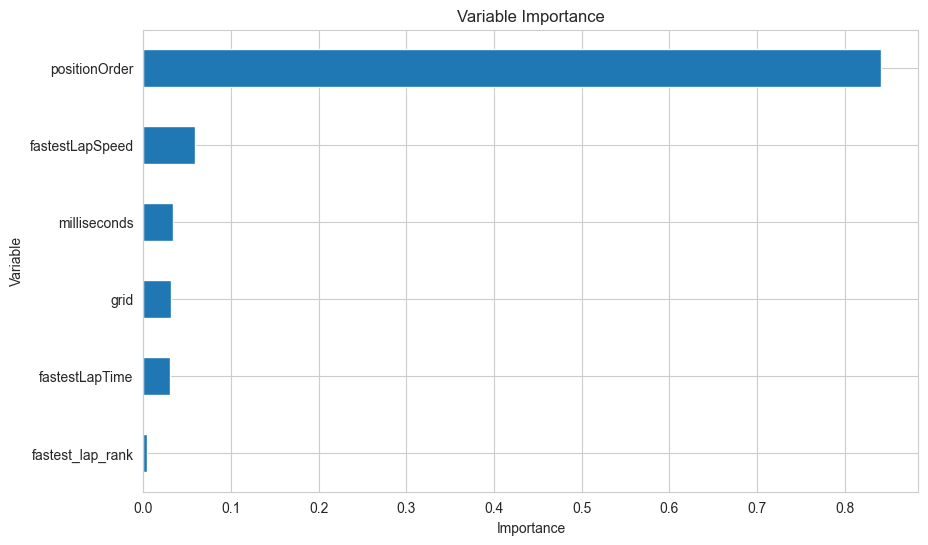

In [ ]:
# Obtener la importancia de las variables
importances = pd.Series(tree_5.feature_importances_, index=X.columns)

# Visualizar la importancia de las variables
plt.figure(figsize=(10,6))
importances.sort_values().plot(kind='barh')
plt.xlabel('Importance')
plt.ylabel('Variable')
plt.title('Variable Importance')
plt.show()

Observamos la importancia de nuestras variables en este modelo. Como ya hemos repetido anteriormente, la variable "positionOrder" es bastante importante en nuestro proyecto, pero en este caso, también podemos destacar la importancia de "fastestLapSpeed". Esto se debe a que en la F1, si un piloto hace la vuelta rápida y queda entre los 10 primeros, obtiene 1 punto adicional, por eso se le da importancia a esta característica.

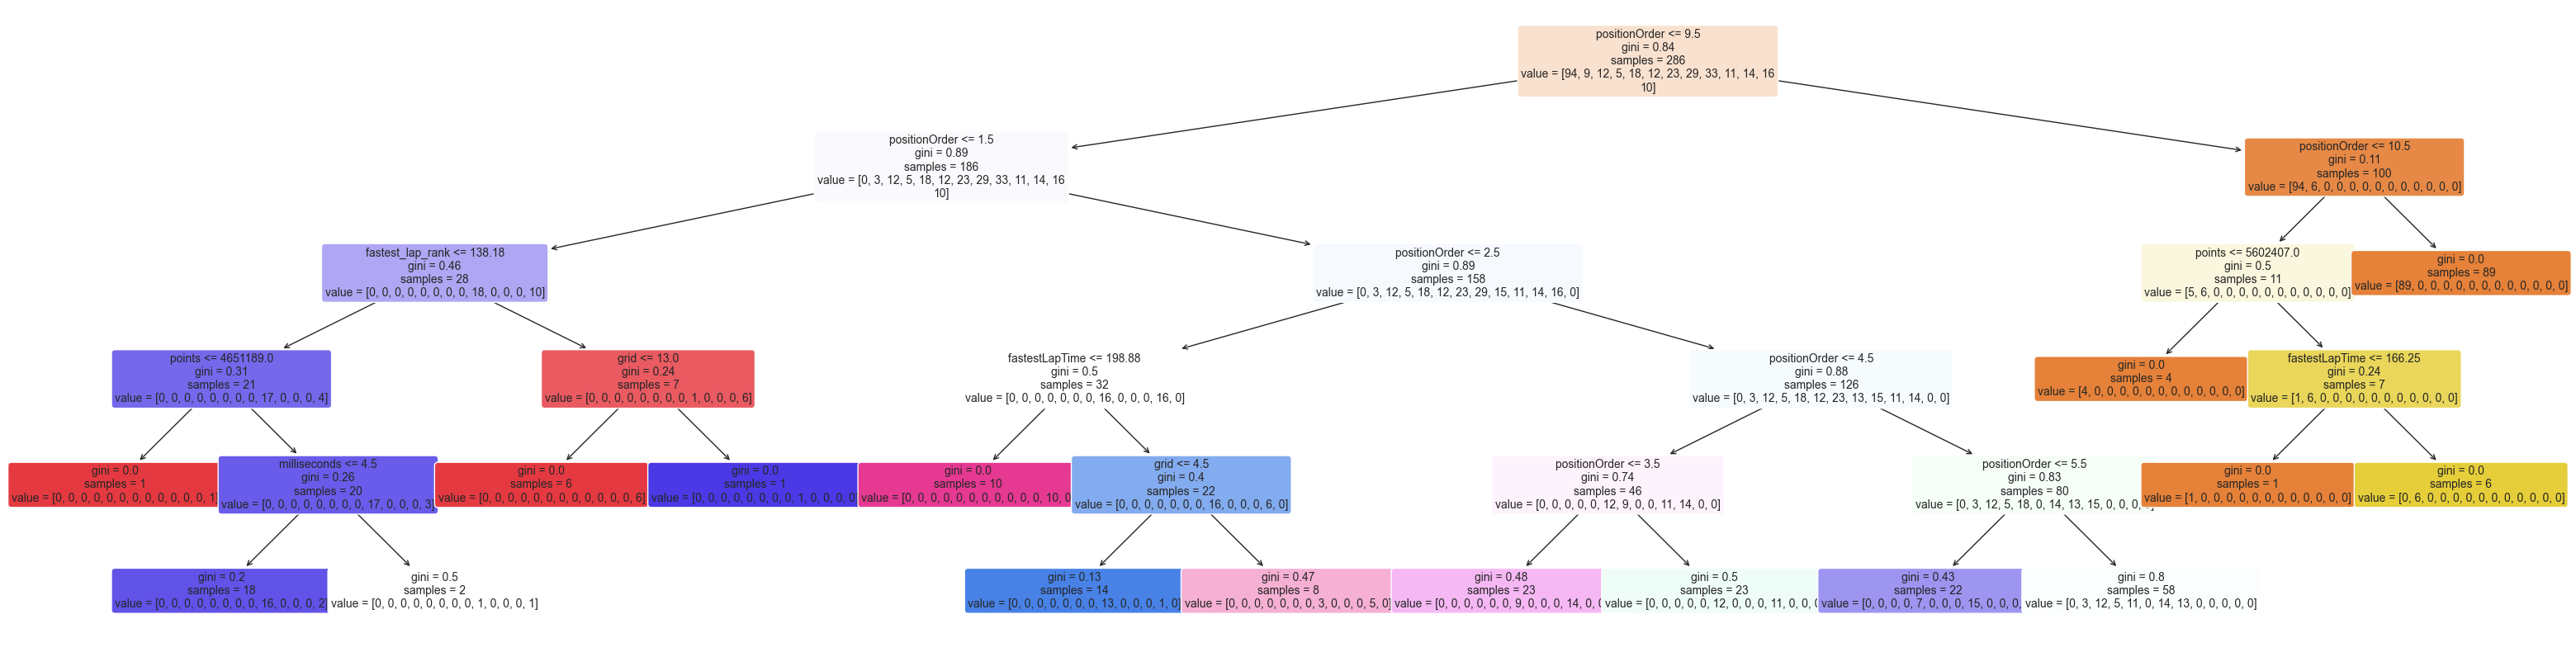

In [ ]:
plt.figure(figsize=(40,10))
arbol_5 = plot_tree(tree_5, feature_names = df_alonso_scaled.columns, rounded = True, 
                    proportion = False, precision = 2, filled = True, fontsize=10)

### Comparación entre nuestros 3 modelos y elección final

In [ ]:
data = {'K-Vecinos': [acc_knn, p_knn, r_knn, f1_knn], 'Naive Bayes': [accuracy, p_nb, r_nb, f1_nb], 
       'Árbol-3': [acc_tree_3, p_t3, r_t3, f1_t3], 'Árbol-4': [acc_tree_4, p_t4, r_t4, f1_t4],
       'Árbol-5': [acc_tree_5, p_t5, r_t5, f1_t5]}
pd.DataFrame.from_dict(data, orient='index', columns=['Exactitud', 'Precisión', 'Exhaustividad', 'F1'])

,Exactitud,Precisión,Exhaustividad,F1
K-Vecinos,0.500000,"[0.879, 0.0, 0.0, 0.0, 0.0, 0.25, 0.333, 0.6, ...","[0.725, 0.0, 0.0, 0.0, 0.0, 0.25, 0.286, 0.3, ...","[0.795, 0.0, 0.0, 0.0, 0.0, 0.25, 0.308, 0.4, ..."
Naive Bayes,0.458333,"[0.909, 0.0, 0.0, 0.2, 0.0, 0.125, 0.167, 0.0,...","[0.566, 0.0, 0.0, 0.2, 0.0, 0.333, 0.333, 0.0,...","[0.698, 0.0, 0.0, 0.2, 0.0, 0.182, 0.222, 0.0,..."
Árbol-3,0.638889,"[0.939, 0.5, 0.0, 0.0, 0.0, 1.0, 0.5, 0.6, 0.0...","[1.0, 0.5, 0.0, 0.0, 0.0, 0.267, 0.6, 0.75, 0....","[0.969, 0.5, 0.0, 0.0, 0.0, 0.421, 0.545, 0.66..."
Árbol-4,0.638889,"[0.939, 0.5, 0.0, 1.0, 0.0, 0.0, 0.5, 0.6, 0.0...","[1.0, 0.5, 0.0, 0.25, 0.0, 0.0, 0.75, 0.75, 0....","[0.969, 0.5, 0.0, 0.4, 0.0, 0.0, 0.6, 0.667, 0..."
Árbol-5,0.694444,"[0.939, 0.5, 0.0, 0.0, 1.0, 0.5, 0.5, 1.0, 0.0...","[1.0, 0.5, 0.0, 0.0, 0.5, 0.25, 1.0, 0.625, 0....","[0.969, 0.5, 0.0, 0.0, 0.667, 0.333, 0.667, 0...."
